### Statisical Tests

In [4]:
%matplotlib inline
import emoji
import scattertext as st
import preprocessor as p
import re, io
import pandas as pd
import numpy as np
from pprint import pprint
from scipy.stats import rankdata, hmean, norm
from matplotlib import pyplot as plt
import seaborn as sns

# Set iPython's max column width to 1000
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
df = pd.read_json('distweets.json')

In [6]:
#clean up text write as a function 
#Remove RT and links from full_text this was already done for the translated text when translating .
#p.set_options(p.OPT.URL, p.OPT.MENTION,p.OPT.HASHTAG,p.OPT.RESERVED,p.OPT.NUMBER)
clean = p.clean
df['clean_text_count'] = [clean(x) for x in df['full_text']]
df['tran_clean_text_count'] = [clean(x) for x in df['tran_full_text']]


#put everything to lowercase 
df['clean_text_count'] = [x.lower() for x in df['clean_text_count']]
df['tran_clean_text_count'] = [x.lower() for x in df['tran_clean_text_count']]


#remove punctuations, digitis, triple periods and japanese punctuations and japanese emojis 
punc = lambda x: re.sub("!|,|\?|\'|-|\"|&|。|\)|\(|！|，|\.*|/|\[|\]|\u2026|\d|:|~|、|？|☆|’|– |【|】|「|」|《|》|※| “|”|＊|→||[\b\.\b]{3}||@||@ |#|# |", '',x)
df['clean_text_count']= [punc(x) for x in df['clean_text_count']]
df['tran_clean_text_count'] = [punc(x) for x in df['tran_clean_text_count']]


#remove emoji 
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
rem_emoji = lambda x: re.sub(r,'',x)
df['clean_text_count']= [rem_emoji(x) for x in df['clean_text_count']]
df['tran_clean_text_count'] = [rem_emoji(x) for x in df['tran_clean_text_count']]

#combine Japanese translation and English text into one column 
df['en_ja_txt_count'] = np.where(df['tran_clean_text_count'] != '', df['tran_clean_text_count'], df['clean_text_count'])

In [7]:
tweets = pd.DataFrame()
tweets['user_screen_name'] = df['user_screen_name']
tweets['user_favorite'] = df['user_fav_count']
tweets['user_follower'] = df['user_fol_count']
tweets['retweet'] = df['retweet']
tweets['retweet_count'] = df['rt_retweet_count']
tweets['retweet_fav_count'] = df['rt_favorite_count']
tweets['clean_translated_text'] = df['en_ja_txt_count']
tweets['original_text'] = df['full_text']
tweets['clean_text'] = df['clean_text_count']
tweets['hashtag'] = df['text_hashtags']
tweets['emoji'] = df['text_emoji']
tweets['text_length'] = df['text_length']
tweets['language'] = df['lang']
tweets['created'] = df['created_at']
tweets['retweet_created'] = df['rt_created_at']
tweets['source'] = df['source']
tweets['retweet_source'] = df['rt_source']
tweets['location'] = df['user_location'].fillna(value='')
tweets['retweetID'] = df['rt_id']
tweets['retweet_created'] = df['rt_created_at']
#getting rid of the quotes
tweets['hashtag'] = tweets['hashtag'].str.replace('\'','')
tweets['emoji'] = tweets['emoji'].str.replace('\'','')

#our word search to try to seperate the two resorts 
tweets['clean_text_hashtag'] = tweets[['clean_translated_text', 'hashtag']].apply(lambda x: ' '.join(x), axis=1)

#add in emoji for sentiment analysis
tweets['clean_text_hashtag_emoji'] = tweets[['clean_text_hashtag','emoji']].apply(lambda x: ' '.join(x), axis=1)

#### Text Blob Sentiment Analysis 

In [8]:
from textblob import TextBlob

def get_tweet_sentiment(tweet):
    # create TextBlob object of passed tweet text
    analysis = TextBlob(tweet)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [9]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
tweets['polarity_tb'] = tweets['clean_text_hashtag_emoji'].apply(pol)
tweets['subjectivity_tb'] = tweets['clean_text_hashtag_emoji'].apply(sub)

In [10]:
tweets['sentiment_text_blob'] = tweets['clean_text_hashtag_emoji'].apply(lambda tweet: get_tweet_sentiment(tweet))                 

#### Vader Sentiment Analysis

In [11]:
#https://stackoverflow.com/questions/47760662/sentiment-analysis-in-python-textblob-vs-vader
#https://github.com/cjhutto/vaderSentiment#about-the-scoring
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    if score['compound']>= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def vader_compound(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

def vader_positive(sentence):
    score = analyser.polarity_scores(sentence)
    return score['pos']


In [12]:
#vader positive score 
tweets['vader_pos'] = [vader_positive(x) for x in tweets['clean_text_hashtag_emoji']]

In [13]:
vader = lambda x: sentiment_analyzer_scores(x)
tweets['sentiment_vader'] = [vader(x) for x in tweets['clean_text_hashtag_emoji']]

In [14]:
#vader compound
tweets['vader_score'] = [vader_compound(x) for x in tweets['clean_text_hashtag_emoji']]

In [15]:
#add in original text with hashtag and emoji 
tweets['original_clean_text_hashtag_emoji'] = tweets[['clean_text','emoji','hashtag']].apply(lambda x: ' '.join(x), axis=1)

#### Asari Sentiment Analysis

In [16]:
from asari.api import Sonar
sonar = Sonar()

def asari(sentence):
    score = sonar.ping(sentence)
    return score['top_class']

/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/justin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator _SigmoidCalibration from version 0.20.2 when using version 0.20.3. This might lead to breaking c

In [17]:
tweets['sentiment_asari'] = [asari(x) for x in tweets['original_clean_text_hashtag_emoji']]

#### Classifying Tweet to see which Disney Resort was visited

In [18]:
#Classifying which park 
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text, re.I)
    if match:
        return True
    return False

In [19]:
tweets['mentions'] = df['at_mentions']
tweets['mentions'] = tweets['mentions'].str.replace('\'','')
tweets['clean_text_hashtag_emoji_mentions'] = tweets[['clean_text_hashtag_emoji','mentions']].apply(lambda x: ' '.join(x), axis=1)
tweets['original_clean_text_hashtag_emoji_mentions'] = tweets[['original_clean_text_hashtag_emoji','mentions']].apply(lambda x: ' '.join(x), axis=1)

In [20]:
tweets['disneyAnaheim'] = tweets['clean_text_hashtag_emoji_mentions'].apply(lambda tweet: word_in_text(r'(disneylandresort|\
disneyresort|CaliforniaAdventure|downtowndisney|disneyanaheim|disneylandanaheim|disneycalifornia|\
californiadisney|california|oogies|oogieboogie|boogie|galaxysedge|mainstreet|dlr|dca|main street|electrical parade|\
starwars|galaxys edge|LAdiseneyland|anaheimdisneyland|anaheim|neworleanssquare|uber|main st|starwars|\
galaxy|disneymom|space mtn|André the Giant at Disneyland|LA|TheGoldbergsABC|DisneylandAP|DLP|catherine powells|\
catherine|star wars|catherine powell|deaddilf69|stormyamaya|mickeys trickortreat|vogue_ivy|monsters inc|\
marvel movies|thunder mountain|matterhorn|avengers|space mountain|snapchat|disneyspook|hollywood|\
opinionstage|jack skellington|universal studios|mcqueen|leia|downtown disney|jedi|orangegrove55)', tweet))

In [21]:
tweets['disneyTokyo'] = tweets['original_clean_text_hashtag_emoji_mentions'].apply(lambda tweet: word_in_text(r'(disneysea|\
disneytokyo|disneytokyoresort|tokyodisney|tokyodisneyresort|tokyodisneyland|tokyo disneyland|\
tdr_info|東京ディズニーランド|ディズニーランド|東京ディズニーシー|ズニーシー|tdr_now|tdr_md|ディズニーランド|\
tokyo|japan|スプーキーbooパレード|ディズニーランド|TDR|tora0422|スペースマウンテン|ドナルド|マイロ|ミニ|disney_04150420|\
spookybooparade|仮装|カストーディアルアート|パーク|白雪姫|ディズニー|キッズ|コイン|tokyo trip|シー|tds_010904|hinaarare_duffy\
ダッフィー|disney_hokuto|linepay_jp|mikko_20100518|dtr|taa235|tyako_tako_tako|rinarina61423|jr_mmk0620|\
tokyo disney|maihama_line|andrew_minnie_|新幹線|ちゃん|ガチャ|スカイウォーカ|ハロウィン|dontike36|でたよ|舞浜|t_bisco|\
edama_d|moonstar_y_h|tommmdd|2nd887|bom_schedule|ngntrtr|ワンマンズ|fp|doppo_miku|インディージョーンズ|リゾラ|\
ジャングルクルーズ|鹿児島|トラッシュカン|disney6942|noon123hii|h_meika|katsudonminnie|ファストパス発行|natch000|• tokyo|\
花壇|ミッキ|motorsports0908|mjlove_panda|minnie24pre|_disney_mania_|satosan1118mm|海|saiga_d_mickey|koutaman7|\
snow whites scary adventures)', tweet))

In [22]:
tweets['otherdisneyparks'] = tweets['clean_text_hashtag_emoji_mentions'].apply(lambda tweet: word_in_text(r'(paris|\
shanghai|hongkong|orlando|epcot|magickingdom|animalkingdom|上海ディズニーランド|China|Shanghai Disneyland|\
hong kong|hong kongers|WaltDisneyWorld|hong kongs|eurostar|StopBrexitSaveBritain|Brexit|Sweden|Denmark|EU|\
magic kingdom|jasonisbell|magic|disney world|\*disneyworld|buzz lightyear ride|disneyworld|jan koeppen|champsélysées|\
cathykirby65|foshan|british|disneyland paris|jungle festival jungle|florida|france|preordertaiwan|wdw|hkdl)', tweet))

In [23]:
tweets[(tweets['disneyAnaheim'] == False) & (tweets['disneyTokyo'] == False)\
       & (tweets['otherdisneyparks'] == False)].shape

(14571, 36)

In [24]:
#seperate by park 
park = []
for index, tweet in tweets.iterrows():
    if tweet['disneyTokyo']:
        park.append('disneyTokyo')
    else:
        if tweet['disneyAnaheim']:
            park.append('disneyAnaheim')
        else:
            if tweet['otherdisneyparks']:
                park.append('otherdisneyparks')
            else:
                park.append('aboutdisney')
        

tweets['park'] = park

<Figure size 1440x720 with 0 Axes>

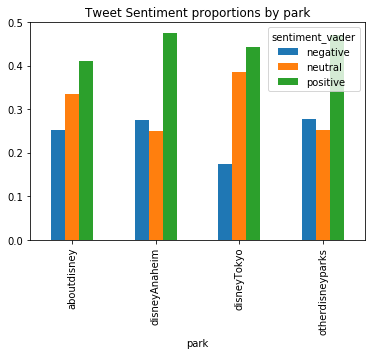

In [28]:
fig = plt.figure(figsize=(20, 10))
sent_by_park = tweets.groupby(['park', 'sentiment_vader']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
sent_by_park.plot(kind = 'bar' )

plt.title('Tweet Sentiment proportions by park')
plt.show()


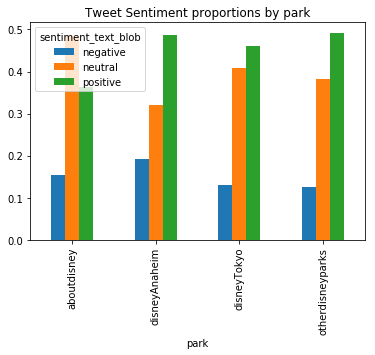

In [26]:
sent_by_park = tweets.groupby(['park', 'sentiment_text_blob']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
sent_by_park.plot(kind = 'bar' )
plt.title('Tweet Sentiment proportions by park')
plt.show()

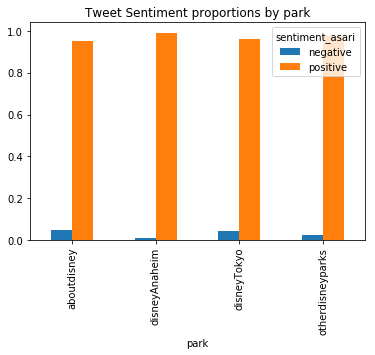

In [27]:
sent_by_park = tweets.groupby(['park', 'sentiment_asari']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
sent_by_park.plot(kind = 'bar' )
plt.title('Tweet Sentiment proportions by park')
plt.show()

#### Positive, Neutral, Negative Count of each Sentiment Analyzer

In [59]:
#counting positive and negatives
tweets.groupby('language')['sentiment_vader'].value_counts()

language  sentiment_vader
en        positive           89905
          negative           50587
          neutral            46777
ja        positive           34942
          neutral            33848
          negative           14791
Name: sentiment_vader, dtype: int64

In [60]:
#counting positive and negatives for textblob
tweets.groupby('language')['sentiment_text_blob'].value_counts()

language  sentiment_text_blob
en        positive               91817
          neutral                60998
          negative               34454
ja        positive               36087
          neutral                35784
          negative               11710
Name: sentiment_text_blob, dtype: int64

In [61]:
tweets.groupby('language')['sentiment_asari'].value_counts()

language  sentiment_asari
en        positive           185695
          negative           1574  
ja        positive           79382 
          negative           4199  
Name: sentiment_asari, dtype: int64

In [62]:
tweets.groupby('park')['sentiment_vader'].value_counts()

park              sentiment_vader
aboutdisney       positive           6034 
                  neutral            4912 
                  negative           3690 
disneyAnaheim     positive           79715
                  negative           46269
                  neutral            41741
disneyTokyo       positive           38754
                  neutral            33784
                  negative           15203
otherdisneyparks  positive           344  
                  negative           216  
                  neutral            188  
Name: sentiment_vader, dtype: int64

In [63]:
tweets.groupby('park')['sentiment_text_blob'].value_counts()

park              sentiment_text_blob
aboutdisney       neutral                7088 
                  positive               5300 
                  negative               2248 
disneyAnaheim     positive               81730
                  neutral                53661
                  negative               32334
disneyTokyo       positive               40497
                  neutral                35751
                  negative               11493
otherdisneyparks  positive               377  
                  neutral                282  
                  negative               89   
Name: sentiment_text_blob, dtype: int64

In [64]:
tweets.groupby('park')['sentiment_asari'].value_counts()

park              sentiment_asari
aboutdisney       positive           13909 
                  negative           727   
disneyAnaheim     positive           166237
                  negative           1488  
disneyTokyo       positive           84201 
                  negative           3540  
otherdisneyparks  positive           730   
                  negative           18    
Name: sentiment_asari, dtype: int64

In [30]:
#Get rid of duplicate retweets 
original = tweets[tweets['retweet'] == 0]
original.shape
retweet = tweets[tweets['retweet'] == 1]
retweet['retweetID'].drop_duplicates(inplace = True)
tweets1 = [original,retweet]
tweets1 = pd.concat(tweets1).reset_index(drop=True)
tweets1 = tweets1.sort_values(by=['created'])

#### Statistical Tests on Sentiment Score

In [31]:
#Quick look at our sentiment numbers 
sentiment = tweets1.loc[:,['vader_score','vader_pos','subjectivity_tb','polarity_tb','language','park']]
sentiment.describe()

,vader_score,vader_pos,subjectivity_tb,polarity_tb
count,"270,850.000","270,850.000","270,850.000","270,850.000"
mean,0.119,0.120,0.368,0.097
std,0.481,0.149,0.320,0.282
min,-1.000,0.000,0.000,-1.000
25%,0.000,0.000,0.000,0.000
50%,0.000,0.069,0.400,0.000
75%,0.459,0.200,0.568,0.258
max,0.999,1.000,1.000,1.000


In [32]:
#lets remove the neutral scores so we have positive and negative 
sentifilter = sentiment.loc[(sentiment.loc[:,sentiment.dtypes != object] != 0).any(1)]
sentifilter.describe()

,vader_score,vader_pos,subjectivity_tb,polarity_tb
count,"221,624.000","221,624.000","221,624.000","221,624.000"
mean,0.146,0.147,0.449,0.118
std,0.528,0.153,0.298,0.308
min,-1.000,0.000,0.000,-1.000
25%,-0.228,0.000,0.233,0.000
50%,0.273,0.111,0.468,0.112
75%,0.527,0.238,0.644,0.292
max,0.999,1.000,1.000,1.000


We had 49,226 tweets that were classified as neutral from our data

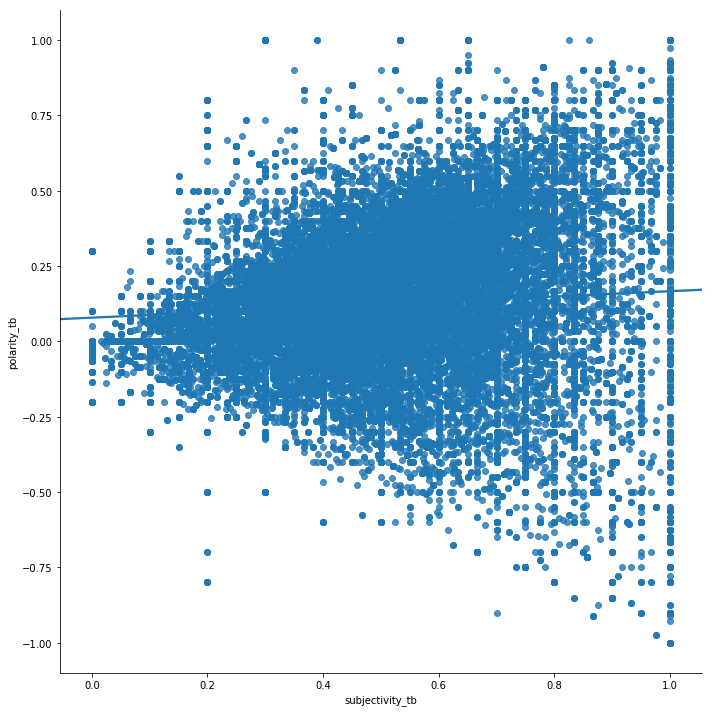

In [68]:
#scatterplot text blob polarity vs subjectivity
sns.lmplot(x='subjectivity_tb',y = 'polarity_tb', data = sentifilter, fit_reg = True,scatter = True, height = 10, palette = 'mute')

In [108]:
from scipy.stats import pearsonr
corr, _ = pearsonr(sentifilter['polarity_tb'], sentifilter['subjectivity_tb'])
print(corr)

0.08505757698038215


Correlation is weak between polarity and subjectivity

Text(0, 0.5, '')

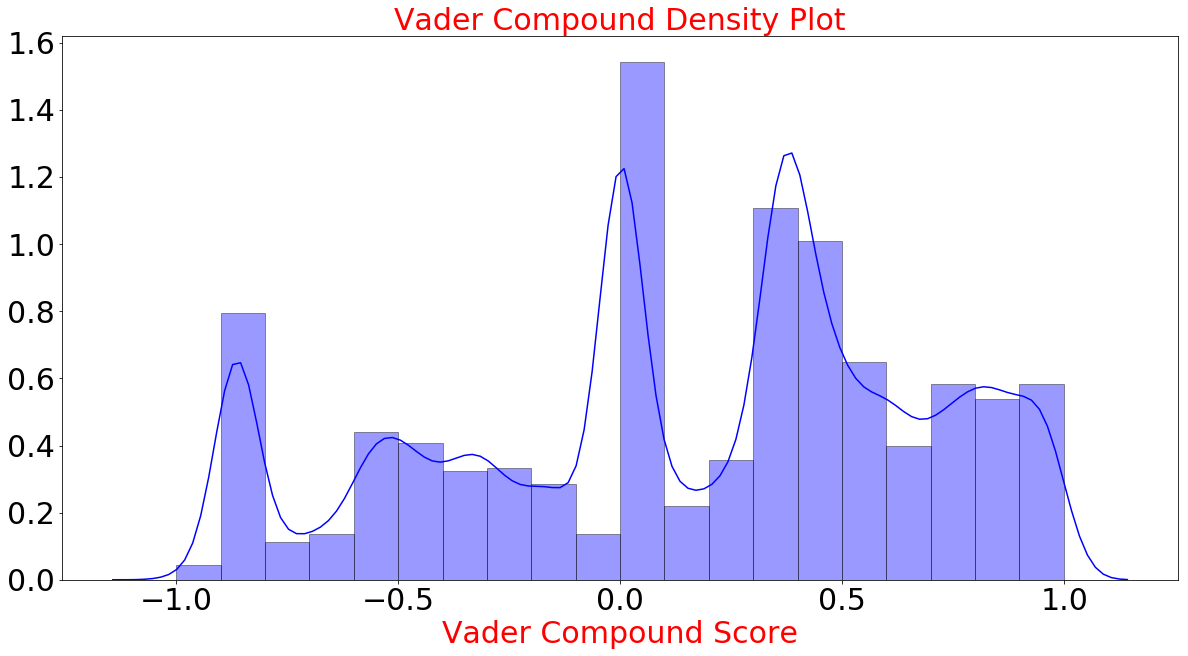

In [127]:


#look at the distrubtion of vader_score
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.distplot(sentifilter['vader_score'], hist = True, kde = True, bins = 20, color = 'blue',
            hist_kws={'edgecolor':'black'}, axlabel = 'vader_score')


ax.axes.set_title('Vader Compound Density Plot',fontsize=30, color = 'r')
ax.set_xlabel('Vader Compound Score',fontsize=30, color = 'r')
ax.tick_params(labelsize=30)
ax.set_ylabel("",fontsize=20)

The vader compound score from NLTK looks to be trimodal 

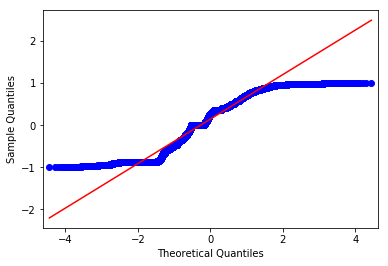

In [42]:
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
qqplot(sentifilter['vader_score'], line='s')
plt.show()


In [133]:
# normality test
stat, p = shapiro(sentifilter['vader_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.951, p=0.000
Sample does not look Gaussian (reject H0)


/Users/justin/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Text(0, 0.5, '')

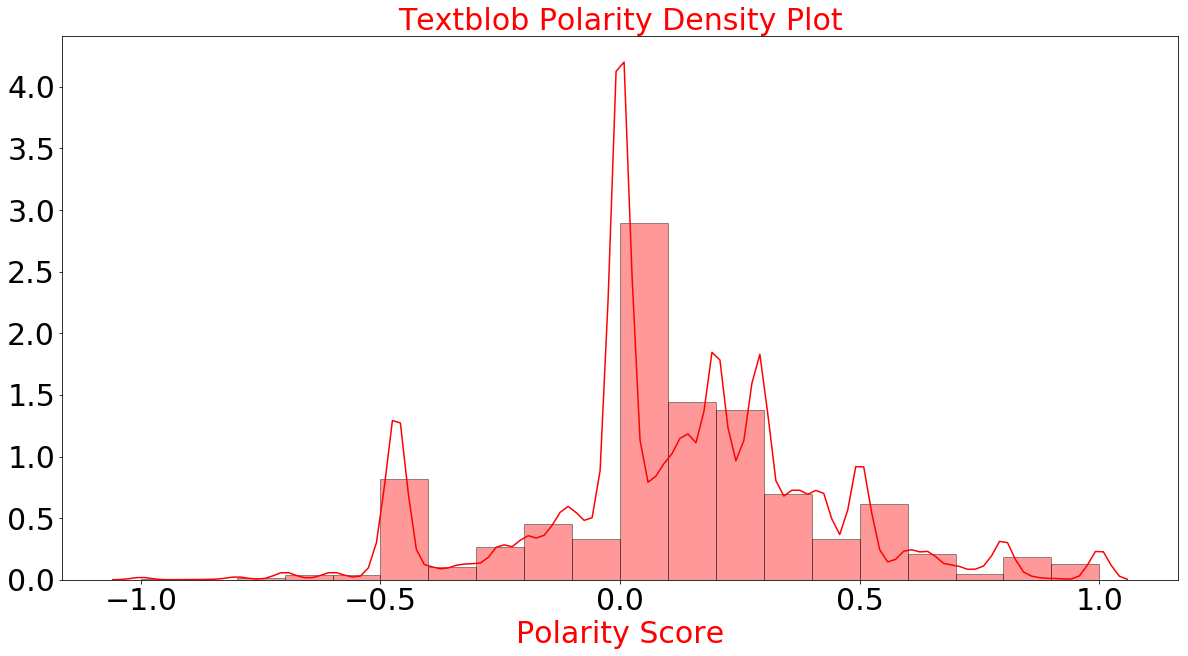

In [75]:
#look at the distrubtion of the textblob polarity 
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.distplot(sentifilter['polarity_tb'], hist = True, kde = True, bins = 20, color = 'red',
            hist_kws={'edgecolor':'black'})


ax.axes.set_title('Textblob Polarity Density Plot',fontsize=30, color = 'r')
ax.set_xlabel('Polarity Score',fontsize=30, color = 'r')
ax.tick_params(labelsize=30)
ax.set_ylabel("",fontsize=20)

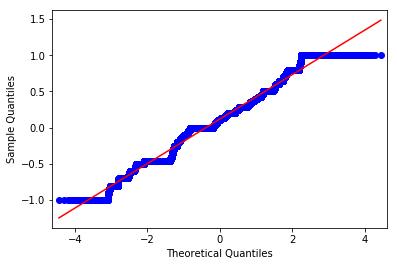

In [131]:
qqplot(sentifilter['polarity_tb'], line='s')
plt.show()

In [134]:
# normality test
stat, p = shapiro(sentifilter['polarity_tb'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.970, p=0.000
Sample does not look Gaussian (reject H0)


/Users/justin/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Hypothesis Test: Difference Between Means

$H_{0}$ = English and Japanese twitters users have the same Polarity and Vader Compound with their sentiment to disney parks  

$H_{0}$: μ 1 = μ 2
  
$H_{A}$ = English and Japanese twitter users have different Polarity and Vader Compound with their sentinment torwards the disney parks

$H_{A}$: μ 1 ≠ μ 2

Using 0.05 significance level


Assumptions 
    * Simple Random Sampling -> Sampling method: all possible samples of n objects are equally likely to occur
    * Two events are independent when the occurrence of one does not affect the probability of the occurrence of the other.
    * The sampling distribution is approximately normal

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

positive sentiment : (compound score >= 0.05)
neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
negative sentiment : (compound score <= -0.05)

In [81]:
#Mean difference by lanugage by compound score 
import math  
mean_vad = pd.DataFrame(sentifilter.groupby('language')['vader_score'].mean())
std_vad = pd.DataFrame(sentifilter.groupby('language')['vader_score'].std())
pop_en = sentifilter[sentifilter['language'] == 'en'].shape[0]
pop_ja = sentifilter[sentifilter['language'] == 'ja'].shape[0]

#mean difference polarity textblob 
mean_tb = pd.DataFrame(sentifilter.groupby('language')['polarity_tb'].mean())
std_tb = pd.DataFrame(sentifilter.groupby('language')['polarity_tb'].std())

In [82]:
#T-stat Vader Compound and Textblob Polarity
#vader
x1 = ((std_vad['vader_score'][0])**2/pop_en) 
x2 = ((std_vad['vader_score'][1]**2)/pop_ja)
SE_vad = math.sqrt(x1 + x2)
print(f'Standard Error for VADER compound is: {SE_vad:.4f}')
mean_diff_vad = mean_vad['vader_score'][0] - mean_vad['vader_score'][1]
print(f'The mean difference for VADER compound is: {mean_diff_vad:.4f}')
tstat_vad = (abs(mean_diff_vad) - 0)/SE_vad
print(f'The calculated t-stat for VADER compound is: {tstat_vad:.4f}')

#textblob
x1 = ((std_tb['polarity_tb'][0])**2/pop_en) 
x2 = ((std_tb['polarity_tb'][1]**2)/pop_ja)
SE_tb = math.sqrt(x1 + x2)
print(f'Standard Error for TextBlob Polarity is: {SE_tb:.4f}')
mean_diff_tb = mean_tb['polarity_tb'][0] - mean_tb['polarity_tb'][1]
print(f'The mean difference for TextBlob Polarity is: {mean_diff_tb:.4f}')
tstat_tb = (abs(mean_diff_tb) - 0)/SE_tb
print(f'The calculated t-stat for TextBlob Polarity is: {tstat_tb:.4f}')

Standard Error for VADER compound is: 0.0024
The mean difference for VADER compound is: -0.1117
The calculated t-stat for VADER compound is: 47.4353
Standard Error for TextBlob Polarity is: 0.0013
The mean difference for TextBlob Polarity is: -0.0101
The calculated t-stat for TextBlob Polarity is: 7.9732


In [83]:
#double checking our math 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
from scipy import stats
tweets_ja = sentifilter[sentifilter['language'] =='ja']
tweets_en = sentifilter[sentifilter['language'] == 'en']
ttest_vad = stats.ttest_ind(tweets_ja['vader_score'], tweets_en['vader_score'], equal_var = False)
ttest_tb = stats.ttest_ind(tweets_ja['polarity_tb'], tweets_en['polarity_tb'], equal_var = False)

print(f'The t-stat for Vader Compound is: {ttest_vad[0]:.4f} \n The p-value for Vader Compound is: {ttest_vad[1]:.4f} \n The t-stat for TextBlob Polarity is: {ttest_tb[0]:.4f} \n The p-value for TextBlob Polarity is: {ttest_tb[1]:.4f}')

The t-stat for Vader Compound is: 47.4353 
 The p-value for Vader Compound is: 0.0000 
 The t-stat for TextBlob Polarity is: 7.9732 
 The p-value for TextBlob Polarity is: 0.0000


A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis. Looking at the Vader Compound and TextBlob sentiment analyzers we would conclude that Japanese Twitter users and English users have different Polarity and that Japanese users are relatively more positive when tweeting about Disney parks. 

In [84]:
print(sentifilter.groupby(['park'])['vader_score'].mean())
print(sentifilter.groupby(['park'])['vader_score'].std())

park
aboutdisney        0.132
disneyAnaheim      0.091
disneyTokyo        0.262
otherdisneyparks   0.172
Name: vader_score, dtype: float64
park
aboutdisney        0.492
disneyAnaheim      0.540
disneyTokyo        0.490
otherdisneyparks   0.445
Name: vader_score, dtype: float64


In [85]:
print(sentifilter.groupby(['park'])['polarity_tb'].mean())
print(sentifilter.groupby(['park'])['polarity_tb'].std())

park
aboutdisney        0.116
disneyAnaheim      0.106
disneyTokyo        0.143
otherdisneyparks   0.149
Name: polarity_tb, dtype: float64
park
aboutdisney        0.326
disneyAnaheim      0.332
disneyTokyo        0.242
otherdisneyparks   0.287
Name: polarity_tb, dtype: float64


Hypothesis Test: Difference Between Means

$H_{0}$ = Twitter users have the same Polarity and Vader Compound with their sentiment for Disney Tokyo and Anaheim

$H_{0}$: μ 1 = μ 2
  
$H_{A}$ = Twitter users have the different Polarity and Vader Compound with their sentiment for Disney Tokyo and Anaheim

$H_{A}$: μ 1 ≠ μ 2

Using 0.05 significance level


Assumptions 
    * Simple Random Sampling -> Sampling method: all possible samples of n objects are equally likely to occur
    * Two events are independent when the occurrence of one does not affect the probability of the occurrence of the other.
    * The sampling distribution is approximately normal

In [86]:
#Use the scipy library to compare the mean difference 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
from scipy import stats
tweets_ja = sentifilter[sentifilter['park'] =='disneyAnaheim']
tweets_en = sentifilter[sentifilter['park'] == 'disneyTokyo']
ttest_vad = stats.ttest_ind(tweets_ja['vader_score'], tweets_en['vader_score'], equal_var = False)
ttest_tb = stats.ttest_ind(tweets_ja['polarity_tb'], tweets_en['polarity_tb'], equal_var = False)

print(f'The t-stat for Vader Compound is: {ttest_vad[0]:.4f} \n The p-value for Vader Compound is: {ttest_vad[1]:.4f} \n The t-stat for TextBlob Polarity is: {ttest_tb[0]:.4f} \n The p-value for TextBlob Polarity is: {ttest_tb[1]:.4f}')

The t-stat for Vader Compound is: -72.1417 
 The p-value for Vader Compound is: 0.0000 
 The t-stat for TextBlob Polarity is: -28.5743 
 The p-value for TextBlob Polarity is: 0.0000


In [ ]:
#What if the central limit theorem doesn't hold 

Mann-Whitney U Test

Tests whether the distributions of two independent samples are equal or not.

Assumptions

Observations in each sample are independent and identically distributed (iid).
Observations in each sample can be ranked.
Interpretation

$H_{0}$: the distributions of both samples are equal.

$H_{A}$: the distributions of both samples are not equal.


In [167]:
#Disneyparks have same sentiment non parametric test 
#https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(tweets_ja['vader_score'], tweets_en['vader_score'])
print('stat: %.3f, p: %.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat: 3995368617.500, p: 0.000
Probably different distributions


In [166]:
stat, p = mannwhitneyu(tweets_ja['polarity_tb'], tweets_en['polarity_tb'])
print('stat: %.3f, p: %.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat: 4644357434.500, p: 0.000
Probably different distributions


In [168]:
#Do Japanese users have different distribution than English Users with sentiment to Disney 
stat, p = mannwhitneyu(tweets_ja['vader_score'], tweets_en['vader_score'])
print('stat: %.3f, p: %.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat: 3995368617.500, p: 0.000
Probably different distributions


In [169]:
stat, p = mannwhitneyu(tweets_ja['polarity_tb'], tweets_en['polarity_tb'])
print('stat: %.3f, p: %.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat: 4644357434.500, p: 0.000
Probably different distributions


In [87]:
print(sentifilter.groupby(['park','language'])['vader_score'].describe())

                                count  mean   std    min    25%   50%   75%  \
park             language                                                     
aboutdisney      en       8,768.000   0.132 0.496 -0.998 -0.296 0.153 0.572   
                 ja       2,439.000   0.131 0.480 -0.999 -0.202 0.152 0.494   
disneyAnaheim    en       140,431.000 0.089 0.540 -1.000 -0.340 0.262 0.459   
                 ja       1,865.000   0.240 0.531 -0.994 -0.161 0.402 0.746   
disneyTokyo      en       8,787.000   0.486 0.497 -0.981 0.000  0.637 0.946   
                 ja       58,680.000  0.229 0.480 -0.994 0.000  0.250 0.625   
otherdisneyparks en       593.000     0.131 0.430 -0.927 -0.077 0.000 0.459   
                 ja       61.000      0.574 0.378 -0.527 0.421  0.851 0.851   

                            max  
park             language        
aboutdisney      en       0.999  
                 ja       0.978  
disneyAnaheim    en       0.999  
                 ja       0.992  
disne

In [88]:
print(sentifilter.groupby(['park','language'])['polarity_tb'].describe())

                                count  mean   std    min   25%   50%   75%  \
park             language                                                    
aboutdisney      en       8,768.000   0.112 0.334 -1.000 0.000 0.000 0.303   
                 ja       2,439.000   0.131 0.295 -1.000 0.000 0.050 0.282   
disneyAnaheim    en       140,431.000 0.105 0.333 -1.000 0.000 0.100 0.292   
                 ja       1,865.000   0.181 0.257 -1.000 0.000 0.172 0.340   
disneyTokyo      en       8,787.000   0.274 0.228 -1.000 0.113 0.367 0.425   
                 ja       58,680.000  0.123 0.238 -1.000 0.000 0.095 0.247   
otherdisneyparks en       593.000     0.146 0.295 -0.910 0.000 0.125 0.318   
                 ja       61.000      0.178 0.198 -0.250 0.055 0.055 0.287   

                            max  
park             language        
aboutdisney      en       1.000  
                 ja       1.000  
disneyAnaheim    en       1.000  
                 ja       1.000  
disneyTokyo    

In [110]:
tweets1.describe()

,user_favorite,user_follower,retweet,retweet_count,retweet_fav_count,retweets,text_length,retweetID,polarity_tb,subjectivity_tb,vader_pos,vader_score
count,"261,722.000","261,722.000","270,850.000","184,266.000","184,266.000","184,266.000","270,850.000","184,266.000","270,850.000","270,850.000","270,850.000","270,850.000"
mean,"26,835.982","4,680.897",0.680,"3,181.855","10,986.021","3,181.855",122.554,"1,181,684,418,819,351,040.000",0.097,0.368,0.120,0.119
std,"55,209.252","232,985.435",0.466,"7,865.703","27,646.744","7,865.703",66.094,"20,489,013,433,542,560.000",0.282,0.320,0.149,0.481
min,0.000,0.000,0.000,1.000,0.000,1.000,1.000,"1,605,958,454.000",-1.000,0.000,0.000,-1.000
25%,"1,682.000",93.000,0.000,9.000,44.000,9.000,71.000,"1,179,510,293,000,000,000.000",0.000,0.000,0.000,0.000
50%,"8,399.000",278.000,1.000,118.000,382.000,118.000,108.000,"1,184,221,404,500,000,000.000",0.000,0.400,0.069,0.000
75%,"27,533.000",701.000,1.000,"1,851.000","4,871.750","1,851.000",155.000,"1,187,535,711,000,000,000.000",0.258,0.568,0.200,0.459
max,"2,230,897.000","78,807,958.000",1.000,"149,274.000","425,986.000","149,274.000",969.000,"1,190,182,867,000,000,000.000",1.000,1.000,1.000,0.999


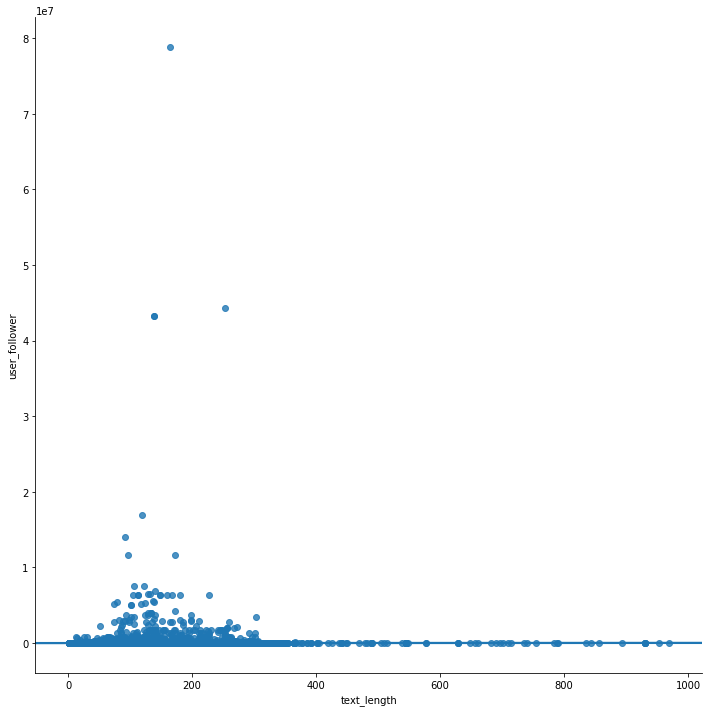

In [92]:
#Correlation between text_length and user_followers
sns.lmplot(x='text_length',y = 'user_follower', data = tweets1, fit_reg = True,scatter = True, height = 10, palette = 'mute')

In [146]:
text_l = tweets1['text_length'].dropna()
user_fol = tweets1['user_follower'].replace(np.nan,0)
corr, _ = pearsonr(text_l,user_fol)
print(f'The correlation between retweet count and favorite count is: {corr:.3f}')

0.006201243725659399


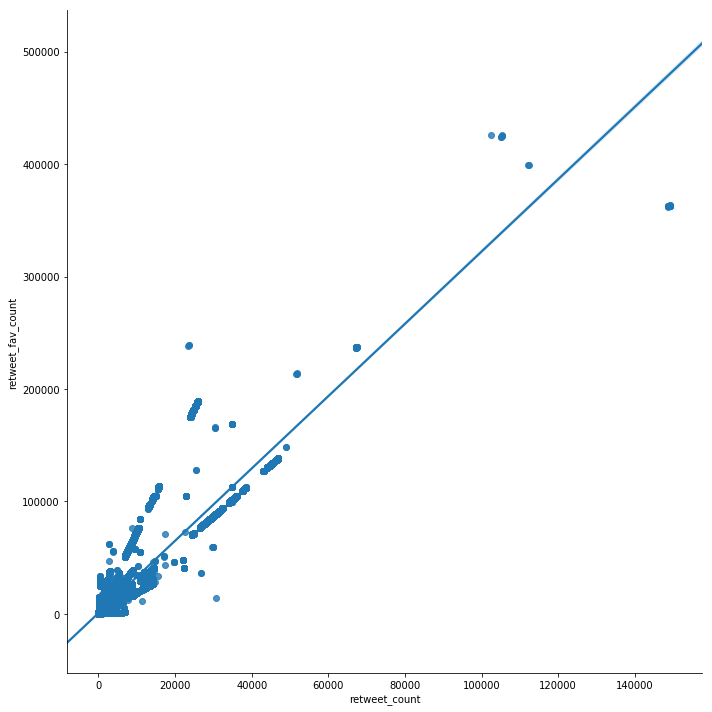

In [143]:
sns.lmplot(x='retweet_count',y = 'retweet_fav_count', data = tweets1, fit_reg = True,scatter = True, height = 10, palette = 'mute')

In [140]:
rt_count = tweets1['retweet_count'].dropna()
rt_fav = tweets1['retweet_fav_count'].dropna()
corr, _ = pearsonr(rt_count, rt_fav)
print(f'The correlation between retweet count and favorite count is: {corr:.3f}')


The correlation between retweet count and favorite count is: 0.915


In [161]:
heatmap = tweets1.loc[:,['user_favorite','user_follower','retweet','retweet_count','retweet_fav_count', 'text_length',
                         'polarity_tb', 'subjectivity_tb', 'vader_pos', 'vader_score']]
heatmap = heatmap.replace(np.nan,0)

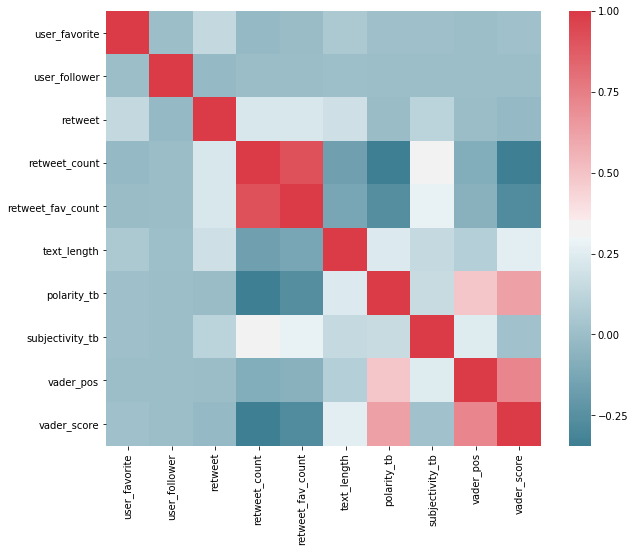

In [162]:
#Sns Heatmap 
f, ax = plt.subplots(figsize=(10, 8))
corr = heatmap.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [163]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,user_favorite,user_follower,retweet,retweet_count,retweet_fav_count,text_length,polarity_tb,subjectivity_tb,vader_pos,vader_score
user_favorite,1,-0.0019,0.14,-0.023,-0.0093,0.06,0.0098,0.009,-0.0021,0.014
user_follower,-0.0019,1,-0.02,-0.0056,-0.0054,0.0062,0.0017,0.00089,-0.0005,0.0016
retweet,0.14,-0.02,1,0.22,0.22,0.18,-0.013,0.12,-0.0027,-0.019
retweet_count,-0.023,-0.0056,0.22,1,0.92,-0.16,-0.34,0.32,-0.092,-0.34
retweet_fav_count,-0.0093,-0.0054,0.22,0.92,1,-0.13,-0.26,0.28,-0.071,-0.27
text_length,0.06,0.0062,0.18,-0.16,-0.13,1,0.24,0.15,0.088,0.26
polarity_tb,0.0098,0.0017,-0.013,-0.34,-0.26,0.24,1,0.16,0.49,0.62
subjectivity_tb,0.009,0.00089,0.12,0.32,0.28,0.15,0.16,1,0.25,0.023
vader_pos,-0.0021,-0.0005,-0.0027,-0.092,-0.071,0.088,0.49,0.25,1,0.72
vader_score,0.014,0.0016,-0.019,-0.34,-0.27,0.26,0.62,0.023,0.72,1
